#### Abstract: Predict whether income exceeds $50K/yr based on census data. Also known as "Census Income" dataset.

#### 50 000 USD per year is about 4 167 USD monthly. <br> In Poland 1USD = 3,73PLN now, so monthly this is about 15 542PLN, and per year 186 500PLN

SOURCE:<br>
http://archive.ics.uci.edu/ml/datasets/Adult <br>
https://www.kaggle.com/overload10/adult-census-dataset/tasks

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic


In [73]:
heading =['age', 'workclass', 'fnlwgt', 'education', 'education-num','marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country','income']
df = pd.read_csv("adult_data.txt", header=None, names = heading)
print(df.shape)
df.head()

(32561, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### How many people in dataset have income >50K or <=50K

 <=50K    24720
 >50K      7841
Name: income, dtype: int64


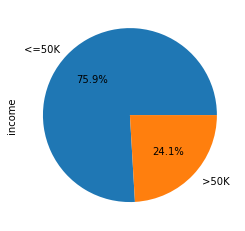

In [100]:
print(df['income'].value_counts())
df['income'].value_counts().plot.pie(autopct='%1.1f%%')

More people earn above or equal 5OK $.

### How about native countries?

In [112]:
print(df['native-country'].value_counts())

 United-States                 29170
 Mexico                          643
 ?                               583
 Philippines                     198
 Germany                         137
 Canada                          121
 Puerto-Rico                     114
 El-Salvador                     106
 India                           100
 Cuba                             95
 England                          90
 Jamaica                          81
 South                            80
 China                            75
 Italy                            73
 Dominican-Republic               70
 Vietnam                          67
 Guatemala                        64
 Japan                            62
 Poland                           60
 Columbia                         59
 Taiwan                           51
 Haiti                            44
 Iran                             43
 Portugal                         37
 Nicaragua                        34
 Peru                             31
 

### GENDER AND INCOME

sex      income
 Female   <=50K     9592
          >50K      1179
 Male     <=50K    15128
          >50K      6662
Name: income, dtype: int64


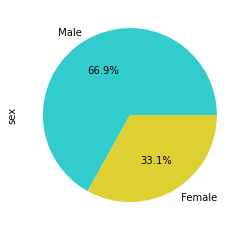

<Figure size 720x432 with 0 Axes>

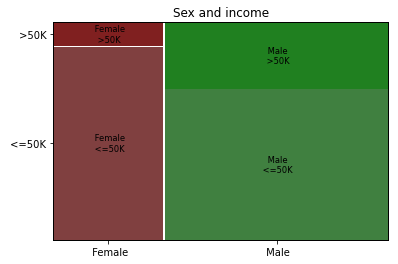

In [109]:
sex_income = pd.DataFrame({'sex': df['sex'], 'income': df['income']})
data = sex_income.income.groupby([sex_income.sex,  sex_income.income]).size()
print(data)
df['sex'].value_counts().plot.pie(autopct='%1.1f%%', colors=['#33cccc','#ded033'])
plt.figure(figsize=(10,6))
mosaic(data, title = "Sex and income")
plt.show()

That's interesting that in data the egender of the smaller number is the female

There is no official information where this census comes from, but after the number of native people from the states, I assume that from the States.

According to goverment data, the US population is more balanced. In 2010 it was 49.2 males to 50.8 females.<br>
Source: https://www.census.gov/prod/cen2010/briefs/c2010br-03.pdf

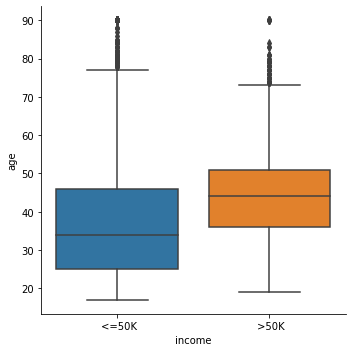

In [45]:
sns.catplot(x='income', y='age', kind="box", data=df)

In [72]:
print('precise median age for >50K income : ',df[df['income']==' >50K']['age'].median(), 'yrs')

precise median age for >50K income :  44.0 yrs


In [71]:
print('precise median age for <=50K income : ',df[df['income']==' <=50K']['age'].median(), 'yrs')

precise median age for <=50K income :  34.0 yrs


MEDIAN value for people earning <=50K is around 35yrs, presicely.<br>
MEDIAN value for people earing >50K is around 45yrs.<br>
50% people who earn <=50K are between around 25 and 45. <br>
50% people who earn >50K are between around 38 and 50. <br>
IQR for >50K is visibly narrower than for <=50K.<br>